# Tools for inspecting individual beacons

See the README.md for setup.

NB: This notebook is unreliable unless cells are run one at a time.

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import matplotlib.ticker
import datetime
import collections
import pickle
# Depends on: pip install --upgrade google-cloud-bigquery
from google.cloud import bigquery

# Some matplotlib features are version dependent.
assert(matplotlib.__version__ >= '2.1.2')
print "Done"

Done


# Global flags

Invoke cell individually or reorder them to change defaults

In [2]:
EndDate = '2018-05-13'
project = 'mlab-sandbox'
dataset_id = 'mattmathis'

In [3]:
# Force queries
DoQueries=True

In [4]:
# Enable interactive figures that pan and zoom
interactive = True

In [5]:
# Enables figures to load inline in the browser and saved (github etc).
interactive = False

In [6]:
# Disable plots for the paper
DoPaper = False

In [7]:
def setupmatplotlib(force=None):
    global interactive
    if force == 'inline':
        %matplotlib inline
        return
    elif force == 'interactive':
        %matplotlib
        return
    elif force is not None:
        print 'Unknown option, using default'
    if interactive:
        print 'default interactive'
        %matplotlib
        return
    else:
        print 'default inline'
        %matplotlib inline
        return
setupmatplotlib()

default inline


In [8]:
# BigQuery interface
def expand_query(query, **kwargs):
    """expand_query: expands nested {parameter} substitutions.
    Stashes forensic output in globals.
    """
    global DebugQuery # For pasting into BQ, after the fact
    global NumberedQuery # For grocking BQ error line numbers.
    global DefaultArgs # To ignore some 

    # Only allow argument substitution 4 levels deep, because
    # accidental infinite recursion risks crashing the notebook.
    args = DefaultArgs.copy()
    args.update(kwargs)
    query=query.format(**args)
    query=query.format(**args)
    query=query.format(**args)
    query=query.format(**args)
    if '{' in query:
        raise "Unexpanded substitutions"
    
    # Leave crumbs incase we need a postmortem
    DebugQuery = query
    NumberedQuery = ""
    for i, l in enumerate(query.split('\n')):
          NumberedQuery += "%3d %s\n"%(i, l)

    return query

def run_query(query, project=project, otherindex=None, timeindex='partition_date', **kwargs):
    """ run_query
        Accepts nested {parameter} substitutions.
        
        Stashes forensic output in globals.
    """
    global NumberedQuery
    query=expand_query(query,  **kwargs)

    # do the work
    client = bigquery.Client(project=project)
    job = client.query(query)  # All errors are delayed

    # Marshal the results, catching async errors
    try:
        results = collections.defaultdict(list)
        for row in job.result(timeout=300):
            for key in row.keys():
                results[key].append(row.get(key)) 
    except:
        print NumberedQuery
        raise

    if otherindex:
        return pd.DataFrame(results, index=results[timeined])
    if timeindex:
        return pd.DataFrame(results, index=pd.DatetimeIndex(results[timeindex]))
    # set timeindex=None to force a raw DataFrame
    return pd.DataFrame(results)

def write_query_table(query, otable,
                      project=project,
                      dataset_id=dataset_id,
                      **kwargs):
    """ write_query_table
        Accepts nested {parameter} substitutions.
        
        Stashes forensic output in globals.
    """
    global NumberedQuery
    query=expand_query(query,  **kwargs)

    # do the work
    client = bigquery.Client(project=project)
    job_config = bigquery.QueryJobConfig()
    table_ref = client.dataset(dataset_id).table(otable)
    job_config.destination = table_ref
    job_config.write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE
    job = client.query(query, location='US', job_config=job_config)

    # Marshal the results, catching async errors
    try:
        res = job.result()  # Get the first row to make sure it starts
        while not job.done():
            print 'tick'
            time.sleep(5)
        assert job.state == 'DONE'
    except:
        print "Query Errored"
        print NumberedQuery
        raise
    print "Query completed"
    return

# test code
if False:
    testQ="""
    SELECT *
    FROM `{dateset_id}.master_annotations`
    """
    write_query_table(testQ, otable='test_results2')

print "Done"

Done


In [9]:
def unlog(x, pos):
    v = math.pow(10, x)
    frac, whole = math.modf(v)
    if frac > 0:
        return '%.1f' % v
    else:
        return '%d' % whole

logFormatter = matplotlib.ticker.FuncFormatter(unlog)
print "Done"

Done


## Query templates for the plots below

In [10]:
# All of these queries yield timeseries of multidimensional histograms of 'value'

# Query the list of beacons
BeaconQ ="""
SELECT
  clientIP {beacon_fields}
FROM
  `{dataset_id}.master_annotations`
WHERE
  clientIP NOT IN (
    '45.56.98.222',
    '64.9.225.99',
    '64.9.225.190' ) # exclude eb, etc
    {beacon_where}
"""

# Query relevant fields of the beacons of interest
# This yields one row per test
# with download rate (Mb/s) in column 'value'
DownloadQ="""
SELECT
  partition_date,
  web100_log_entry.connection_spec.remote_ip AS clientIP,
  connection_spec.data_direction AS direction,
  web100_log_entry.connection_spec.local_ip AS local_ip,
  IFNULL(SUBSTR(connection_spec.server_hostname, -25, 5),
         "UNK") AS server_site,
  IFNULL(SUBSTR(connection_spec.server_hostname, -25, 3),
         "UNK") AS server_metro,
  web100_log_entry.log_time AS test_time,
  web100_log_entry.snap.duration AS duration,
  web100_log_entry.snap.HCDataOctetsOut AS bytes_transfered,
  {more_data}
  SAFE_DIVIDE(web100_log_entry.snap.HCDataOctetsOut, web100_log_entry.snap.duration) * 8 AS value
FROM
  `measurement-lab.release.ndt_all`
WHERE
  connection_spec.data_direction = 1
  AND web100_log_entry.snap.duration > 10000
  AND web100_log_entry.snap.HCDataOctetsOut > 0
  AND web100_log_entry.snap.HCDataOctetsOut < 1625000000
  {data_where}
  AND partition_date <= '{enddate}' 
"""

# Query relevant fields of the beacons of interest
# This yields one row per test
# with upload rate (Mb/s) in column 'value'
UploadQ="""
SELECT
  partition_date,
  web100_log_entry.connection_spec.remote_ip AS clientIP,
  connection_spec.data_direction AS direction,
  web100_log_entry.connection_spec.local_ip AS local_ip,
  IFNULL(SUBSTR(connection_spec.server_hostname, -25, 5),
         "UNK") AS server_site,
  IFNULL(SUBSTR(connection_spec.server_hostname, -25, 3),
         "UNK") AS server_metro,
  web100_log_entry.log_time AS test_time,
  web100_log_entry.snap.duration AS duration,
  web100_log_entry.snap.HCDataOctetsIn AS bytes_transfered,
  {more_data}
  SAFE_DIVIDE(web100_log_entry.snap.HCDataOctetsIn, web100_log_entry.snap.duration) * 8 AS value
FROM
  `measurement-lab.release.ndt_all`
WHERE
  connection_spec.data_direction = 0
  AND web100_log_entry.snap.duration > 10000
  AND web100_log_entry.snap.HCDataOctetsIn > 0
  AND web100_log_entry.snap.HCDataOctetsIn < 1625000000
  {data_where}
  AND partition_date <= '{enddate}' 
"""

# Query relevant fields of the beacons of interest
# This yields one row per test
# with RTT in column 'value'
RTTQ="""
SELECT
  partition_date,
  web100_log_entry.connection_spec.remote_ip AS clientIP,
  connection_spec.data_direction AS direction,
  web100_log_entry.connection_spec.local_ip AS local_ip,
  IFNULL(SUBSTR(connection_spec.server_hostname, -25, 5),
         "UNK") AS server_site,
  IFNULL(SUBSTR(connection_spec.server_hostname, -25, 3),
         "UNK") AS server_metro,
  web100_log_entry.log_time AS test_time,
  web100_log_entry.snap.duration AS duration,
  web100_log_entry.snap.HCDataOctetsOut AS bytes_transfered, 
  SAFE_DIVIDE(web100_log_entry.snap.SumRTT, web100_log_entry.snap.CountRTT) AS value
FROM
  `measurement-lab.release.ndt_all`
WHERE
  connection_spec.data_direction = 1
  AND web100_log_entry.snap.duration > 10000
  AND web100_log_entry.snap.HCDataOctetsOut > 0
  AND web100_log_entry.snap.HCDataOctetsOut < 1625000000
  {data_where}
  AND partition_date <= '{enddate}' 
"""

# Query relevant fields of the beacons of interest
# This yields one row per test
# with MinRTT in column 'value'
MinRTTQ="""
SELECT
  partition_date,
  web100_log_entry.connection_spec.remote_ip AS clientIP,
  connection_spec.data_direction AS direction,
  web100_log_entry.connection_spec.local_ip AS local_ip,
  IFNULL(SUBSTR(connection_spec.server_hostname, -25, 5),
         "UNK") AS server_site,
  IFNULL(SUBSTR(connection_spec.server_hostname, -25, 3),
         "UNK") AS server_metro,
  web100_log_entry.log_time AS test_time,
  web100_log_entry.snap.duration AS duration,
  web100_log_entry.snap.HCDataOctetsOut AS bytes_transfered, 
  web100_log_entry.snap.MinRTT AS value
FROM
  `measurement-lab.release.ndt_all`
WHERE
  connection_spec.data_direction = 1
  AND web100_log_entry.snap.duration > 10000
  AND web100_log_entry.snap.HCDataOctetsOut > 0
  AND web100_log_entry.snap.HCDataOctetsOut < 1625000000
  {data_where}
  AND partition_date <= '{enddate}' 
"""

# Joinclause
joinQ = """
    SELECT *
    FROM ( {data} )
    INNER JOIN ( {beacons} )
    USING ( clientIP )
"""

# Aggregate test statistics by partition_date and server_site
mainQ="""
#standardSQL
SELECT
  UNIX_DATE(partition_date) * 86400 AS partition_time,
  partition_date,
  server_site,
  ANY_VALUE(server_metro) AS server_metro,
  COUNTIF(value < 1.0) AS LT001,
  COUNTIF(value < 2.0) AS LT002,
  COUNTIF(value < 4.0) AS LT004,
  COUNTIF(value < 8.0) AS LT008,
  COUNTIF(value < 16.0) AS LT016,
  COUNTIF(value < 32.0) AS LT032,
  COUNTIF(value < 64.0) AS LT064,
  COUNTIF(value < 128.0) AS LT128,
  COUNTIF(value < 256.0) AS LT256,
  COUNTIF(value < 512.0) AS LT512,
  COUNT(*) AS count
FROM ( {joinclause} )
GROUP BY
  partition_date,
  server_site
ORDER BY
  partition_date
"""

global EndDate # pervent irrelevant changes
# Default values for optional parameters
DefaultArgs = {
    'beacons':BeaconQ,
    'beacon_fields':'',
    'beacon_where':'',
    'data':DownloadQ,
    'more_data':'',
    'data_where':'',
    'enddate':EndDate,
    'joinclause':joinQ,
    'dataset_id':dataset_id
}

# Useful debugging queries
CountQ="""
#standardSQL
SELECT
    count(*) AS count
FROM ( {counted} )
"""

LimitQ="""
#standardSQL
SELECT
    *
FROM ( {counted} ) LIMIT 10
"""

print "Done"

Done


In [11]:
# 

# beacon slectors
first1000beacons="""
  ORDER BY series_start ASC LIMIT 1000
"""

greedybeacons="""
  ORDER BY series_download_bytes DESC LIMIT 100
"""

longestbeacons="""
    ORDER BY series_elapsed_days DESC LIMIT 100
"""

selectedBeaconQ ="""
SELECT
  clientIP {beacon_fields}
FROM
  `{dataset_id}.master_annotations`
WHERE
  clientIP IN ( {roguesgallery} )
"""

beacon_fields=", series_start, series_start_asc, series_count, series_download_bytes, series_elapsed_days"

seriesQ="""
SELECT
  UNIX_DATE(partition_date) * 86400 AS partition_time,
  partition_date,
  server_site,
  server_metro,
  clientIP,
  test_time,
  duration,
  bytes_transfered,
  value AS rate
  {beacon_fields}
FROM ( {joinclause} )
ORDER BY test_time ASC
"""
print "Done"

Done


In [12]:
# Confirm that BQ credentials are working
# Count Master Beacons, Should be 1.55M
if True:
        print run_query(CountQ, counted=BeaconQ, timeindex=None)

     count
0  1555329


# Default beacon timeseries plotter

In [13]:
# Base series plotting code
def new_plot_beacon_rates(pdata, ofile=None, title=None, ztime=None, xlim=None, figsize=(16, 20)):
    
    fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=figsize)
   
    ax = axes # was for ax in axes:

    # make it pretty
    ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator())
    if ofile:
        ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
        ax.xaxis.set_minor_formatter(matplotlib.dates.DateFormatter(''))
    else:
        ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y   '))
        #  ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))
        ax.tick_params(axis='x', labelrotation=90)
        ax.xaxis.set_minor_formatter(matplotlib.dates.DateFormatter('%m'))
        
    if xlim is not None:
        ax.set_xlim(xlim)
    # print list(pdata), list(pdata['test_time'])
    rate = pdata['rate']
    if ztime:
        hour = (pdata['test_time'] % 86400) / 3600.0
        ax.plot(rate[hour > ztime], marker='x', linestyle='None', label='')
        ax.plot(rate[hour < ztime], marker='+', linestyle='None', label='')
    else:
        ax.plot(rate, marker='.', linestyle='None', label='')

    # if
    if title and not ofile:
        fig.suptitle(title, y='0.97', fontsize=14)
    if ofile:
        fig.savefig(ofile, dpi=100)
    plt.show()
    # plt.close
# tester needed
print 'Done'

Done


# Search for interesting  beacons
(High rate, frequent or early tests).

In [14]:
# Query and Display the 100 greedyest beacons
# NB: Later logic to exclude beacons with excessive tests per day implicitly excludes most of these too
if DoQueries:
    GreedyBeacons = run_query(seriesQ,
                             beacon_fields=beacon_fields, beacon_where=greedybeacons)
    GreedyBeacons.index=pd.DatetimeIndex(GreedyBeacons['test_time']*1000000000)
    print GreedyBeacons[0:3]
    print 'Query Done'

                     bytes_transfered      clientIP  duration partition_date  \
test_time                                                                      
2009-08-23 08:16:53           4530964  77.48.106.46  10062838     2009-08-23   
2009-09-23 15:26:11            599824  77.48.106.46  10201627     2009-09-23   
2009-11-04 16:18:45           5889884  77.48.106.46  10035652     2009-11-04   

                     partition_time      rate  series_count  \
test_time                                                     
2009-08-23 08:16:53      1250985600  3.602136         10918   
2009-09-23 15:26:11      1253664000  0.470375         10918   
2009-11-04 16:18:45      1257292800  4.695168         10918   

                     series_download_bytes  series_elapsed_days  series_start  \
test_time                                                                       
2009-08-23 08:16:53         51078764874206          2340.521991    1251015399   
2009-09-23 15:26:11         510787648742

# Time series of individual beacons

Done


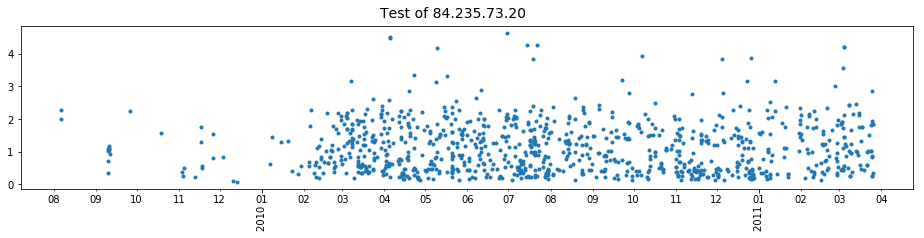

In [15]:
# Detailed plot of manually slected beacons
# Note that thispPredates new master beacons, and many are excluded now
roguesgallery = [
 '144.130.155.1', # Greedy 23 - Strong ~2 MB/s Max + outliers UP
 '163.7.137.201', # Grenew_plot_beacon_ratesedy 25  ~ 850 M/b max but only 2 days
 '163.7.137.243', # Greedy 26 -  850 M/b max, 5 days
 '195.143.162.141', # Greedy 35	- Varying flattop (w/ outliers)
 '204.246.122.65', # Greedy 42 - Varying flattop (w/ outliers) ~ 3 years
 '208.77.130.154', # Greedy 48 - stripes
 '23.228.128.99', # Greedy 52 - stripes
 '45.79.140.244', # Greedy 56 - 850 for ~ 1 day, then 400 Mb/s
 '45.79.155.9', # Greedy 57 - Man test at low rates, two spikes one to 800+
 '77.95.64.13', # Greedy 90 - several days at ~700 Mb/s, downward shift
 '121.54.32.106', # Longest 7 (and many like it) thin viel w/ gaps July 2010, 2012 2016-2017, upward slope
 '217.72.93.226', # Longest 64 - long staircase
 '84.1.111.194', # Longest 93 - long staircase
 '93.99.142.1', # Longest 99 - 3 rate steps but decreasing test volumes
 '121.54.32.102', # First 42 - Another BT?
 # (Through)
 '121.54.32.108', # First 46
 '84.235.73.18', # First 819 - NAT!  Very uniform noisy mostly under 2 MB/s
 '84.235.73.19', # First 820 - NAT!  Very uniform noisy mostly under 2 MB/s
 '84.235.73.20', # First 821 - NAT!  Very uniform noisy mostly under 2 MB/s
 '84.235.73.21', # First 822 - NAT!  Very uniformflat and noisy mostly under 2 MB/s
 '84.235.75.18', # First 823 - NAT!  Very uniform noisy mostly under 2 MB/s
 '84.235.75.21', # First 824 - NAT!  Very uniform noisy mostly under 2 MB/s
]

if True:
    CuratedBeacons = run_query(seriesQ, beacons=selectedBeaconQ, timeindex=None,
                             beacon_fields=beacon_fields, roguesgallery=str(roguesgallery)[1:-1])
    CuratedBeacons.index = pd.DatetimeIndex(CuratedBeacons['test_time']*1000000000)
print 'Done'

# print CuratedBeacons
if True:
    tmp = CuratedBeacons[CuratedBeacons['clientIP'] == '84.235.73.20']
    new_plot_beacon_rates(tmp, title='Test of 84.235.73.20', figsize=(16, 3))

Using matplotlib backend: Qt5Agg


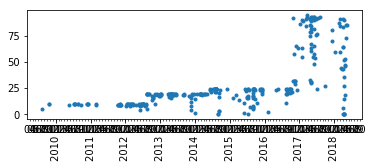

In [16]:
# Paper Figures

PaperDir = '../paper/'
PaperDir = './'
DoPaper = False
if True:
    ofile = None
    if DoPaper:
        ofile = PaperDir+'Selected.png'
        print 'Formating to:', ofile
    %matplotlib
    tmp = pd.DataFrame(CuratedBeacons, copy=True)
    # pdata = tmp.pivot_table(index=tmp.index, columns='clientIP', values='rate')
    new_plot_beacon_rates(tmp[tmp['clientIP']=='217.72.93.226'],
                  ofile=ofile, figsize=(6, 2))